In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Path to save
file_path = '../data/processed/final_bank_loan_data.csv'
df = pd.read_csv(file_path)
df.head()

,Age,Gender,Experience,Income,Family,CCAvg,Education,Mortgage,Home Ownership,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,1,49.0,4,1.6,1,0,1,0,1,0,0.0,0
1,45,1,19,34.0,3,1.5,1,0,2,0,1,0,0.0,0
2,39,1,15,11.0,1,1.0,1,0,2,0,0,0,0.0,0
3,35,1,9,100.0,1,2.7,2,0,2,0,0,0,0.0,0
4,35,1,8,45.0,4,1.0,2,0,2,0,0,0,0.0,1


In [3]:
# Separate features (X) and target variable (y)
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [5]:
# Function to create the neural network model
def create_model():
    model = nn.Sequential(
        nn.Linear(13, 10),
        nn.ReLU(),
        nn.Linear(10, 5),
        nn.ReLU(),
        nn.Linear(5, 1),
        nn.Sigmoid()
    )
    return model

In [6]:
# Function to train the model
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=100):
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Calculate training accuracy
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            predicted = (train_outputs > 0.5).float()
            train_accuracy = (predicted == y_train_tensor).float().mean()
            train_accuracy_history.append(train_accuracy.item())

            test_outputs = model(X_test_tensor)
            predicted = (test_outputs > 0.5).float()
            test_accuracy = (predicted == y_test_tensor).float().mean()
            test_accuracy_history.append(test_accuracy.item())

        print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_accuracy_history, test_accuracy_history

In [7]:
# List of optimizers to evaluate
optimizers = [
    ('SGD', optim.SGD),
    ('Adam', optim.Adam),
    ('RMSprop', optim.RMSprop)
]

In [8]:
results = []

# Iterate over optimizers
for optimizer_name, optimizer_class in optimizers:
    # Create model, optimizer, and loss function
    model = create_model()
    optimizer = optimizer_class(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train the model
    train_accuracy, test_accuracy = train_model(model, optimizer, criterion, train_loader, test_loader)

    # Store results
    results.append({
        'Optimizer': optimizer_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

Epoch [1/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [2/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [3/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [4/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [5/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [6/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [7/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [8/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [9/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [10/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [11/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [12/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [13/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [14/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [15/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [16/100], Train Accuracy: 0.8832, Test Accuracy: 0.8944
Epoch [17/100], T

In [9]:
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Find the row with the maximum test accuracy
best_row = results_df.loc[results_df['Test Accuracy'].apply(lambda x: x[-1]).idxmax()]

# Extract the values
best_optimizer = best_row['Optimizer']
best_train_accuracy = best_row['Train Accuracy'][-1] 
best_test_accuracy = best_row['Test Accuracy'][-1]   

# Print the results
print(f"The best optimizer is: {best_optimizer}")
print(f"Train Accuracy: {best_train_accuracy:.4f}")
print(f"Test Accuracy: {best_test_accuracy:.4f}")

The best optimizer is: Adam
Train Accuracy: 0.9608
Test Accuracy: 0.9620


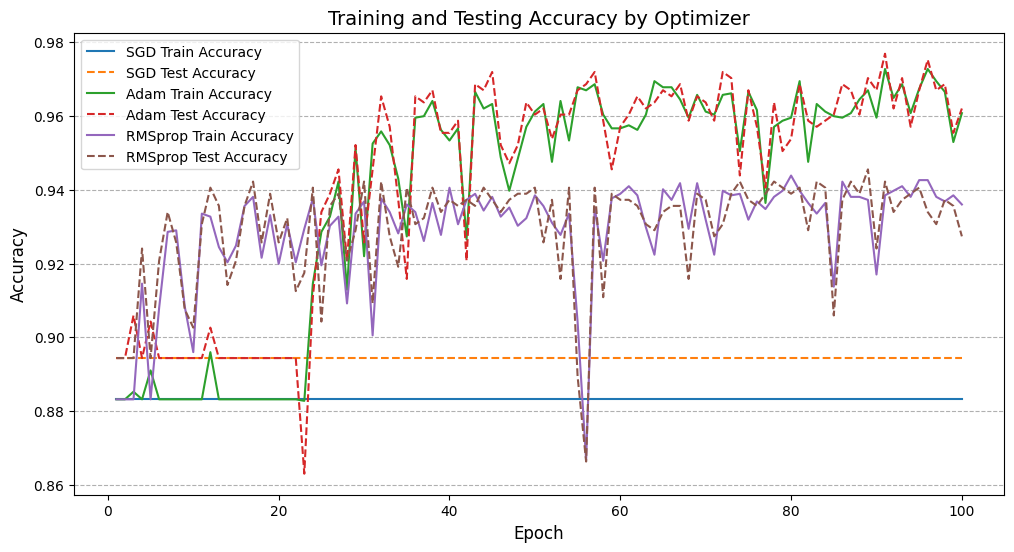

In [10]:
# Create a DataFrame for plotting
plot_df = results_df.explode(['Train Accuracy', 'Test Accuracy'])
plot_df['Epoch'] = plot_df.groupby('Optimizer').cumcount() + 1

# Plot the data for each optimizer
plt.figure(figsize=(12, 6))

for optimizer in plot_df['Optimizer'].unique():
    optimizer_data = plot_df[plot_df['Optimizer'] == optimizer]
    
    # Plot training accuracy
    plt.plot(optimizer_data['Epoch'], optimizer_data['Train Accuracy'], 
             label=f'{optimizer} Train Accuracy', linestyle='-')

    # Plot testing accuracy
    plt.plot(optimizer_data['Epoch'], optimizer_data['Test Accuracy'], 
             label=f'{optimizer} Test Accuracy', linestyle='--')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Testing Accuracy by Optimizer', fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--')  # Add a grid to the y-axis

plt.show()

In [11]:
PATH = '../models/neural_network_bank_loan_model.h5'
torch.save(model.state_dict(), PATH)